# Data processing for GHG emissions of conferences
Data files must be the output .csv files from the 'Travel Footprint Calculator' (TFC) by Didier Barret (https://travel-footprint-calculator.irap.omp.eu/)

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib import cm

In [2]:
# Load files for Conferences
conf = glob.glob("./Calculated_emissions/Conferences/*.csv")
conf.sort()

Our files all begin with three digits that are associated with a unique conference ID, which originated from a list that we compiled for all meetings advertised online.
This is used to distinguish the individual conferences in the following data analysis, since it is helpful to cross-check each individual conference in case of inconsistencies.

In [3]:
### Dealing with the raw data ###
# Assigning countries to continents - only countries with Astronomy institutions assigned!
# --> check if all countries of your participants & venues are listed here!

continent_countries ={
    "Asia":["China","Thailand","Japan","Vietnam","Malaysia","Taiwan","Indonesia","South Korea","Russia",
        "Armenia","Georgia","Azerbaijan","Kazakhstan","India","Iran","Turkey", "United Arab Emirates","Israel",
        "Lebanon","Nepal","Oman","Pakistan","Philippines","Saudi Arabia","Singapore","Sri Lanka","Tajikistan",
        "Uzbekistan","Afghanistan","Bangladesh","Iraq","Jordan","Mongolia","Myanmar","Cambodia"],
    "Africa":["South Africa", "Ethiopia", "Namibia", "Kenya", "Morocco", "Mozambique","Nigeria","Rwanda","Senegal",
         "Tanzania","Tunisia","Uganda","Zambia","Algeria","Botswana","Burkina Faso","Cameroon","Egypt","Eswatini",
         "Ghana", "Sudan","Democratic Republic of the Congo"],
    "Europe":["France", "Denmark","Germany","Poland","Czechia","Czech Republic","Netherlands","Belgium", "Austria","Switzerland",
         "Sweden","Italy","United Kingdom","Ireland","Spain","Portugal","Finland","Slovenia","Iceland","Greece",
         "Bulgaria","Hungary","Ukraine","Latvia","Lithuania", "Malta","North Macedonia","Norway","Romania",
        "Serbia","Slovakia","Albania","Bosnia and Herzegovina","Croatia","Cyprus","Estonia"],
    "North America":["United States","Canada","Mexico","Cuba","British Virgin Islands"],
    "South America":["Argentina", "Brazil","Chile","Peru","Uruguay","Colombia","Ecuador","Nicaragua","Costa Rica","El Salvador",
    "Honduras"],
    "Oceania":["Australia", "New Zealand"]
}

country_continent = {}
for continent, countries in continent_countries.items():
    for country in countries:
        country_continent[country] = continent
        

def _apply_country_continent(country):
    if country in country_continent.keys():
        return country_continent[country]
    else:
        return "unknown"   # if continent == unknown, check sorting above
        

single_dataframe = []
for filepath in conf:
    df = pd.read_csv(filepath, sep=',', skipinitialspace=True)
    df["conference_id"] = os.path.basename(filepath)[:3]
    single_dataframe.append(df)

dataframe = pd.concat(single_dataframe)

dataframe["country"] = dataframe["country"].str.strip()
dataframe["continent"] = dataframe["country"].apply(_apply_country_continent)
dataframe["num_persons"] = dataframe["plane trips_amount"] + dataframe["train trips_amount"]

# Compute number of local participants
dataframe["is_local"] = False
filter_local = dataframe["distance_km"]/dataframe["num_persons"].replace(0,1)/2 <= 100
dataframe.loc[filter_local,"is_local"] = True
dataframe["locals"] = 0
dataframe.loc[dataframe["is_local"]==True,"locals"] = dataframe.loc[dataframe["is_local"]==True,"num_persons"]


In [4]:
# Check to see if all involved countries have been assigned to their continent
# ---> Table should be empty

filterx = dataframe["continent"]=="unknown"
dataframe[filterx]

,location,city,country,address,latitude,longitude,co2_kg,distance_km,plane trips_amount,train trips_amount,conference_id,continent,num_persons,is_local,locals


In [5]:
# Additional check that there is no NaN instead of a continent
count_nan = dataframe["continent"].isna().sum()
print ('Count of NaN: ' + str(count_nan))

Count of NaN: 0


In [6]:
# Looking at one conference individually
# This will list each row in the .csv file
dataframe.loc[dataframe['conference_id'] == '002']

,location,city,country,address,latitude,longitude,co2_kg,distance_km,plane trips_amount,train trips_amount,conference_id,continent,num_persons,is_local,locals
0,"Seattle, United States",Seattle,United States,"Seattle, King County, Washington, United States",47.603832,-122.330062,0.000,0.007,0,118,002,North America,118,True,118
1,"Victoria, Canada",Victoria,Canada,"Victoria, Capital Regional District, British C...",48.428318,-123.364953,100.219,3351.794,0,14,002,North America,14,False,0
2,"Vancouver, Canada",Vancouver,Canada,"Vancouver, District of North Vancouver, Britis...",49.260872,-123.113953,242.514,8110.835,0,21,002,North America,21,False,0
3,"Bellingham, United States",Bellingham,United States,"Bellingham, Whatcom County, Washington, United...",48.754401,-122.478836,291.804,9759.329,0,38,002,North America,38,False,0
4,"Pierre, United States",Pierre,United States,"Pierre, Hughes County, South Dakota, 57501, Un...",44.368364,-100.351137,644.598,3459.191,1,0,002,North America,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"San Francisco, United States",San Francisco,United States,"San Francisco, California, United States",37.779026,-122.419906,94054.269,447922.776,205,0,002,North America,205,False,0
95,"Washington, United States",Washington,United States,"Washington, District of Columbia, United States",38.895037,-77.036543,96412.143,575470.302,77,0,002,North America,77,False,0
96,"Los Angeles, United States",Los Angeles,United States,"Los Angeles, Los Angeles County, California, U...",34.053691,-118.242766,154773.236,824960.497,267,0,002,North America,267,False,0
97,"Boston, United States",Boston,United States,"Boston, Suffolk County, Massachusetts, United ...",42.360253,-71.058291,309948.142,1872005.448,234,0,002,North America,234,False,0


## Data aggregating for all conference
This will produce a panda dataframe where each entry lists the accumulated GHG emissions, participant numbers, etc.

Important: Note that the venue of the conference is selected based on the (first) entry in the original data file that has a value of 0 in the *co2_kg* column. If a meeting takes place at Location A and no participants are from the same location, the venue will not be listed in the original .csv output file and needs to be added manually, in a separate row in the output file. 
Additionally, it can sometimes happen that the TFC computes a very small amount of emissions for participants originating at the meeting venue. This occurs due to the tool setting the geolocation of the venue slightly different than that of the geolocation of the participant origin (usually for large cities that are fairly widespread). In this case, the value in the *co2_kg* column needs to be set to 0 manually for the meeting venue.

In [7]:
### Aggregating all travel emissions per conference ###

data_agg = (dataframe
            .groupby("conference_id")
            .agg({"train trips_amount":sum,
                  "plane trips_amount":sum,
                  "co2_kg": lambda x: sum(x)/1000,
                  "distance_km":sum,
                  "locals":sum
                 }
                )
            .rename(columns={"train trips_amount":"train_trav",
                             "plane trips_amount":"plane_trav",
                             "co2_kg":"co2_output",
                             "distance_km":"travel_distance"
                            }
                   )
           )
data_agg["num_persons"] = data_agg["train_trav"] + data_agg["plane_trav"]
data_agg["emission_per_capita"] = round(data_agg["co2_output"]/data_agg["num_persons"],2)
data_agg["local_perc"] = round((data_agg["locals"]/data_agg["num_persons"])*100.,1)

venue_columns = {"continent":"continent_venue",
                 "country":"country_venue",
                 "latitude":"lat_venue",
                 "longitude":"lon_venue"
                }

# Venue selection based on entry with 0kg of CO2eq emissions
venues = (dataframe[dataframe["co2_kg"]==0]
          .set_index("conference_id")
          .filter(items=sorted(venue_columns.keys()))
          .rename(columns=venue_columns)
         )
data_agg = data_agg.join( venues, how="left", on="conference_id" )

# Print the new table, each row is one conference
data_agg    

,train_trav,plane_trav,co2_output,travel_distance,locals,num_persons,emission_per_capita,local_perc,continent_venue,country_venue,lat_venue,lon_venue
conference_id,,,,,,,,,,,,
002,191,3205,3461.970091,1.997334e+07,118,3396,1.02,3.5,North America,United States,47.603832,-122.330062
003,11,5,3.642373,2.232033e+04,4,16,0.23,25.0,Europe,United Kingdom,51.507322,-0.127647
004,37,22,39.144351,2.582119e+05,2,59,0.66,3.4,Europe,Germany,47.681261,11.761342
005,10,66,186.632648,1.129247e+06,10,76,2.46,13.2,Asia,China,24.883227,102.835103
006,30,87,159.695241,9.559572e+05,26,117,1.36,22.2,North America,Canada,49.260872,-123.113953
...,...,...,...,...,...,...,...,...,...,...,...,...
387,19,18,12.665333,6.831896e+04,19,37,0.34,51.4,Oceania,Australia,-37.814218,144.963161
388,12,7,3.216713,1.519390e+04,12,19,0.17,63.2,Oceania,Australia,-33.854816,151.216454
389,35,60,54.261439,3.051001e+05,0,95,0.57,0.0,Oceania,Australia,-37.424164,143.894520


In [8]:
# Count the number of conferences by continent
cont_df = data_agg.reset_index().groupby(["continent_venue"])["conference_id"].count()
cont_df

continent_venue
Africa             3
Asia              49
Europe           124
North America     59
Oceania           18
South America      5
Name: conference_id, dtype: int64

In [9]:
# Check if a conference_id exists without venue
data_agg[data_agg.isna().any(axis=1)].index

Index([], dtype='object', name='conference_id')

In [10]:
# Several cities around the globe exist multiple times in different countries
# or US states. In order to check if the travel calculator tool has connected
# the correct city with your input file

idx = dataframe.reset_index().groupby(["conference_id","city"]).latitude.count() != 1

(dataframe
 .reset_index()
 .set_index(["conference_id","city"])
 [idx]
 .to_csv("Output_from_Jupyter_Notebook/need_to_check_doppelganger.csv")
)

<ipython-input-10-211413ecaf3c>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (dataframe


## Computing statistics for all meetings considered

In [11]:
### Computation of  statistics ###

all_co2 = round(data_agg["co2_output"].sum(),2)
all_conf = len(data_agg["co2_output"])
mean_emission_per_capita = round(data_agg["emission_per_capita"].mean(),2)
err_emission_per_capita = round(data_agg["emission_per_capita"].std(),2)
median_emission_per_capita = round(data_agg["emission_per_capita"].median(),2)
mean_participants = round(data_agg["num_persons"].mean(),1)
err_participants = round(data_agg["num_persons"].std(),1)
median_participants = round(data_agg["num_persons"].median(),1)
mean_local_participants = round(data_agg["local_perc"].mean(),1)
median_local_participants = round(data_agg["local_perc"].median(),1)
err_local_participants = round(data_agg["local_perc"].std(),1)

# Total distance travelled
travel_dist_2019 = round(sum(dataframe["distance_km"]),0)
travel_dist_earthcirc = round(travel_dist_2019/40075.,2)
travel_dist_au = round(travel_dist_2019/149597870.700,3)

print(f"Number of meetings: {all_conf}")
print(f"Total emitted CO2: {all_co2} tons")
print(f"Mean number of participants per conference: {mean_participants} +/- {err_participants}")
print(f"Median number of participants per conference: {median_participants}")
print(f"Mean emission per participant per conference: {mean_emission_per_capita} +/- {err_emission_per_capita} t CO2/person/meeting")
print(f"Median emission per participant per conference: {median_emission_per_capita} t CO2/person/meeting")
print(f"Mean local participants per conference: {mean_local_participants} +/- {err_local_participants}")
print(f"Median local participants per conference: {median_local_participants}")

print(f"Total distance travelled in 2019: {travel_dist_2019} km")
print(f"Equivalent to {travel_dist_earthcirc} times the circumference of the Earth, or {travel_dist_au} AU")


Number of meetings: 258
Total emitted CO2: 36253.86 tons
Mean number of participants per conference: 128.3 +/- 258.5
Median number of participants per conference: 81.0
Mean emission per participant per conference: 1.1 +/- 0.64 t CO2/person/meeting
Median emission per participant per conference: 1.04 t CO2/person/meeting
Mean local participants per conference: 20.9 +/- 17.7
Median local participants per conference: 17.2
Total distance travelled in 2019: 216024263.0 km
Equivalent to 5390.5 times the circumference of the Earth, or 1.444 AU


In [12]:
# Statistics per continent
(data_agg.reset_index()
 .groupby(["continent_venue"])
 .agg({"conference_id":"nunique", "num_persons":["mean","median","std"],
       "emission_per_capita":["mean","median","std"],"local_perc":["mean","median","std"],
       "co2_output":"sum","travel_distance":"sum"})
)

conference_id num_persons                     \
                      nunique        mean median         std   
continent_venue                                                
Africa                      3   92.666667   76.0   80.307741   
Asia                       49   91.326531   87.0   54.103446   
Europe                    124  127.233871   78.0  208.596709   
North America              59  176.440678   82.0  441.723672   
Oceania                    18   83.222222   83.5   54.579198   
South America               5  132.400000   83.0  115.116463   

                emission_per_capita                  local_perc         \
                               mean median       std       mean median   
continent_venue                                                          
Africa                     1.900000  1.710  0.364280   8.966667   11.1   
Asia                       1.116939  1.100  0.678857  26.065306   25.0   
Europe                     0.976855  0.990  0.475359  17.308871   15.2   
North America              1.159492  1.130  0.564130  22.371186   19.6   
Oceania                    1.612222  1.395  1.202344  24.105556   21.7   
South America              0.844000  0.640  0.844411  39.960000   55.4   

                              co2_output travel_distance  
                       std           sum             sum  
continent_venue                                           
Africa            8.113158    514.844902    3.131737e+06  
Asia             19.517594   5125.146618    3.099133e+07  
Europe           14.444072  16314.657629    9.757536e+07  
North America    18.540804  11074.184448    6.500003e+07  
Oceania          20.947033   2693.915861    1.624212e+07  
South America    28.252575    531.110517    3.083688e+06

### Some examples to filter out specific meetings

In [13]:
# Meetings with more than 350 participants
# filterA =data_agg[data_agg['num_persons'] > 350]
# filterA

# Meetings in North America but not in the United States
filter1 = data_agg[data_agg['continent_venue'] == 'North America']
filter2 = filter1[filter1['country_venue']!='United States']
filter2

# Meetings with less than 20% of local participants
# filterX = data_agg[data_agg['local_perc']<0.2]
# filterX

,train_trav,plane_trav,co2_output,travel_distance,locals,num_persons,emission_per_capita,local_perc,continent_venue,country_venue,lat_venue,lon_venue
conference_id,,,,,,,,,,,,
006,30,87,159.695241,955957.165,26,117,1.364917,22.222222,North America,Canada,49.260872,-123.113953
046,5,104,141.475361,825958.583,0,109,1.297939,0.000000,North America,Mexico,20.649177,-105.224708
069,24,21,19.759255,113993.416,12,45,0.439095,26.666667,North America,Canada,49.494891,-119.594421
072,16,37,81.746864,495994.183,14,53,1.542394,26.415094,North America,Cuba,23.135305,-82.358963
078,22,122,192.945878,1150493.881,21,144,1.339902,14.583333,North America,Canada,48.428318,-123.364953
085,43,87,142.753820,858712.909,38,130,1.098106,29.230769,North America,Canada,45.497216,-73.610364
117,105,197,184.188383,1051639.859,85,302,0.609895,28.145695,North America,Canada,45.497216,-73.610364
137,44,98,164.017508,973684.449,37,142,1.155053,26.056338,North America,Mexico,31.865889,-116.602983
161,13,63,119.580683,724415.763,0,76,1.573430,0.000000,North America,Canada,45.363318,-72.201464


## Plots and data visualisation

In [13]:
# Color definitions
color_africa = '#A7281E'#'#7D998B'
color_asia = '#EB7C3B'#'#BBC794'
color_europe = '#F8B044'#'#F1F2CF'
color_namerica = '#8CD8FD'#'#557E9B'
color_oceania = '#299091'#'#254D8E'
color_samerica = '#0B2C29'#'#00054A'
colors = {'Africa':color_africa,'Asia':color_asia,'Europe':color_europe,'North America':color_namerica,'Oceania':color_oceania,
          'South America':color_samerica}


# Plot font sizes definitions
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rcParams["font.family"] = "serif"

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Plot A: Histogram of emissions per participant with color-coding for each continent

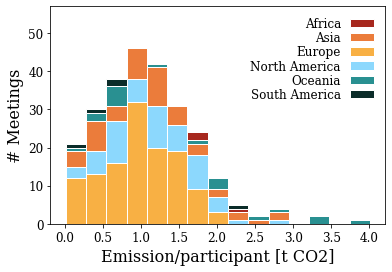

In [14]:
plt.figsize=(10, 10)
fig, ax = plt.subplots()

# Sort the data frame after most meetings
data_pivot = data_agg[["emission_per_capita","continent_venue"]].pivot(columns="continent_venue")
columns_ordered = (data_pivot
                   .sum()
                   .sort_values(ascending=False)
                   .index.get_level_values("continent_venue").values
                  )
data_pivot.columns = data_pivot.columns.droplevel(0)
data_pivot = data_pivot[columns_ordered]

data_pivot.plot(kind="hist", ax=ax, stacked=True, color=colors, ylim=(0,57), bins=15, edgecolor="white", linewidth=1)

handles, labels = plt.gca().get_legend_handles_labels()
order = list(np.argsort(labels))

ax.set_xlabel(r'Emission/participant [t CO2]', fontsize=16)
ax.set_ylabel(r'# Meetings', fontsize=16)
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.0, 1.0),frameon=False,labelspacing=0.1,fontsize=12,markerfirst=False)
fig.savefig('Output_from_Jupyter_Notebook/histogram_capitaemissions_per_continent.pdf', bbox_inches='tight')

### Plot B: Emission per capita vs. number of participants

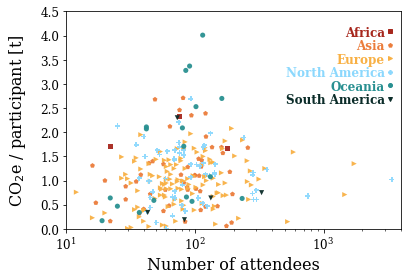

In [15]:
fig, ax = plt.subplots()
# Set x and y ranges
plt.xlim(10, 4000)
plt.ylim(0, 4.5)

#m = data_agg["continent_venue"].map(markers).values
c = data_agg["continent_venue"].map(colors).values
# Plot all together

continent_marker = {
    "Africa":"s",
    "Asia":"p",
    "Europe":">",
    "North America":"P",
    "Oceania":"o",
    "South America":"v"
}
for continent, marker in continent_marker.items():
    data_cont = data_agg[data_agg["continent_venue"] == continent]
    cc = data_cont["continent_venue"].map(colors).values
    plt.scatter(data_cont["num_persons"], data_cont["emission_per_capita"], s=26, c=cc, linewidths=0, marker=marker, alpha=0.95)


plt.xlabel(r'Number of attendees', fontsize=16, labelpad=4)
plt.ylabel(r'CO$_{2}$e / participant [t]', fontsize=16,labelpad=12)

plt.xscale("log")
y=4.2
ydiff=0.28
x=3000
fsize='medium'
plt.text(x, y, 'Africa',
        verticalalignment='top', horizontalalignment='right',
        color=color_africa, fontsize=fsize, weight='bold')
plt.plot(x+300, y-0.4*ydiff, marker="s", color=color_africa, markersize=4)
plt.text(x, y-1*ydiff, 'Asia',
        verticalalignment='top', horizontalalignment='right',
        color=color_asia, fontsize=fsize, weight='bold')
plt.plot(x+300, y-1.4*ydiff, marker="p", color=color_asia, markersize=4)
plt.text(x, y-2*ydiff, 'Europe',
        verticalalignment='top', horizontalalignment='right',
        color=color_europe, fontsize=fsize, weight='bold')
plt.plot(x+300, y-2.4*ydiff, marker=">", color=color_europe, markersize=4)
plt.text(x, y-3*ydiff, 'North America',
        verticalalignment='top', horizontalalignment='right',
        color=color_namerica, fontsize=fsize, weight='bold')
plt.plot(x+300, y-3.4*ydiff, marker="P", color=color_namerica, markersize=4)
plt.text(x, y-4*ydiff, 'Oceania',
        verticalalignment='top', horizontalalignment='right',
        color=color_oceania, fontsize=fsize, weight='bold')
plt.plot(x+300, y-4.4*ydiff, marker="o", color=color_oceania, markersize=4)
plt.text(x, y-5*ydiff, 'South America',
        verticalalignment='top', horizontalalignment='right',
        color=color_samerica, fontsize=fsize, weight='bold')
plt.plot(x+300, y-5.4*ydiff, marker="v", color=color_samerica, markersize=4)
#ax.set_facecolor("#F0F0F0")
#plt.show()

plt.savefig('Output_from_Jupyter_Notebook/correlation_attendees_vs_emissionpercapita.pdf', bbox_inches='tight')

### Plot C: Scatter plot for local participants vs. emission per capita

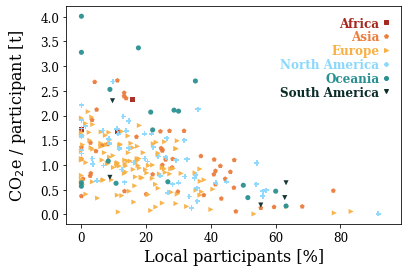

In [16]:
c = data_agg["continent_venue"].map(colors).values

continent_marker = {
    "Africa":"s",
    "Asia":"p",
    "Europe":">",
    "North America":"P",
    "Oceania":"o",
    "South America":"v"
}
for continent, marker in continent_marker.items():
    data_cont = data_agg[data_agg["continent_venue"] == continent]
    cc = data_cont["continent_venue"].map(colors).values
    plt.scatter(data_cont["local_perc"], data_cont["emission_per_capita"], s=26, c=cc, linewidths=0, marker=marker, alpha=0.95)


plt.xlabel(r'Local participants [%]', fontsize=16, labelpad=4)
plt.ylabel(r'CO$_{2}$e / participant [t]', fontsize=16,labelpad=12)

y=4.
ydiff=0.28
fsize='medium'

x=92
plt.text(x, y, 'Africa',
        verticalalignment='top', horizontalalignment='right',
        color=color_africa, fontsize=fsize, weight='bold')
plt.plot(x+2, y-0.4*ydiff, marker="s", color=color_africa, markersize=4)
plt.text(x, y-1*ydiff, 'Asia',
        verticalalignment='top', horizontalalignment='right',
        color=color_asia, fontsize=fsize, weight='bold')
plt.plot(x+2, y-1.4*ydiff, marker="p", color=color_asia, markersize=4)
plt.text(x, y-2*ydiff, 'Europe',
        verticalalignment='top', horizontalalignment='right',
        color=color_europe, fontsize=fsize, weight='bold')
plt.plot(x+2, y-2.4*ydiff, marker=">", color=color_europe, markersize=4)
plt.text(x, y-3*ydiff, 'North America',
        verticalalignment='top', horizontalalignment='right',
        color=color_namerica, fontsize=fsize, weight='bold')
plt.plot(x+2, y-3.4*ydiff, marker="P", color=color_namerica, markersize=4)
plt.text(x, y-4*ydiff, 'Oceania',
        verticalalignment='top', horizontalalignment='right',
        color=color_oceania, fontsize=fsize, weight='bold')
plt.plot(x+2, y-4.4*ydiff, marker="o", color=color_oceania, markersize=4)
plt.text(x, y-5*ydiff, 'South America',
        verticalalignment='top', horizontalalignment='right',
        color=color_samerica, fontsize=fsize, weight='bold')
plt.plot(x+2, y-5.4*ydiff, marker="v", color=color_samerica, markersize=4)


#plt.show()
plt.savefig('Output_from_Jupyter_Notebook/localness_vs_emissionpercapita_allmeetings.pdf', bbox_inches='tight')

### Plot D: Pie chart for conference venue vs. origin of participants

['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']


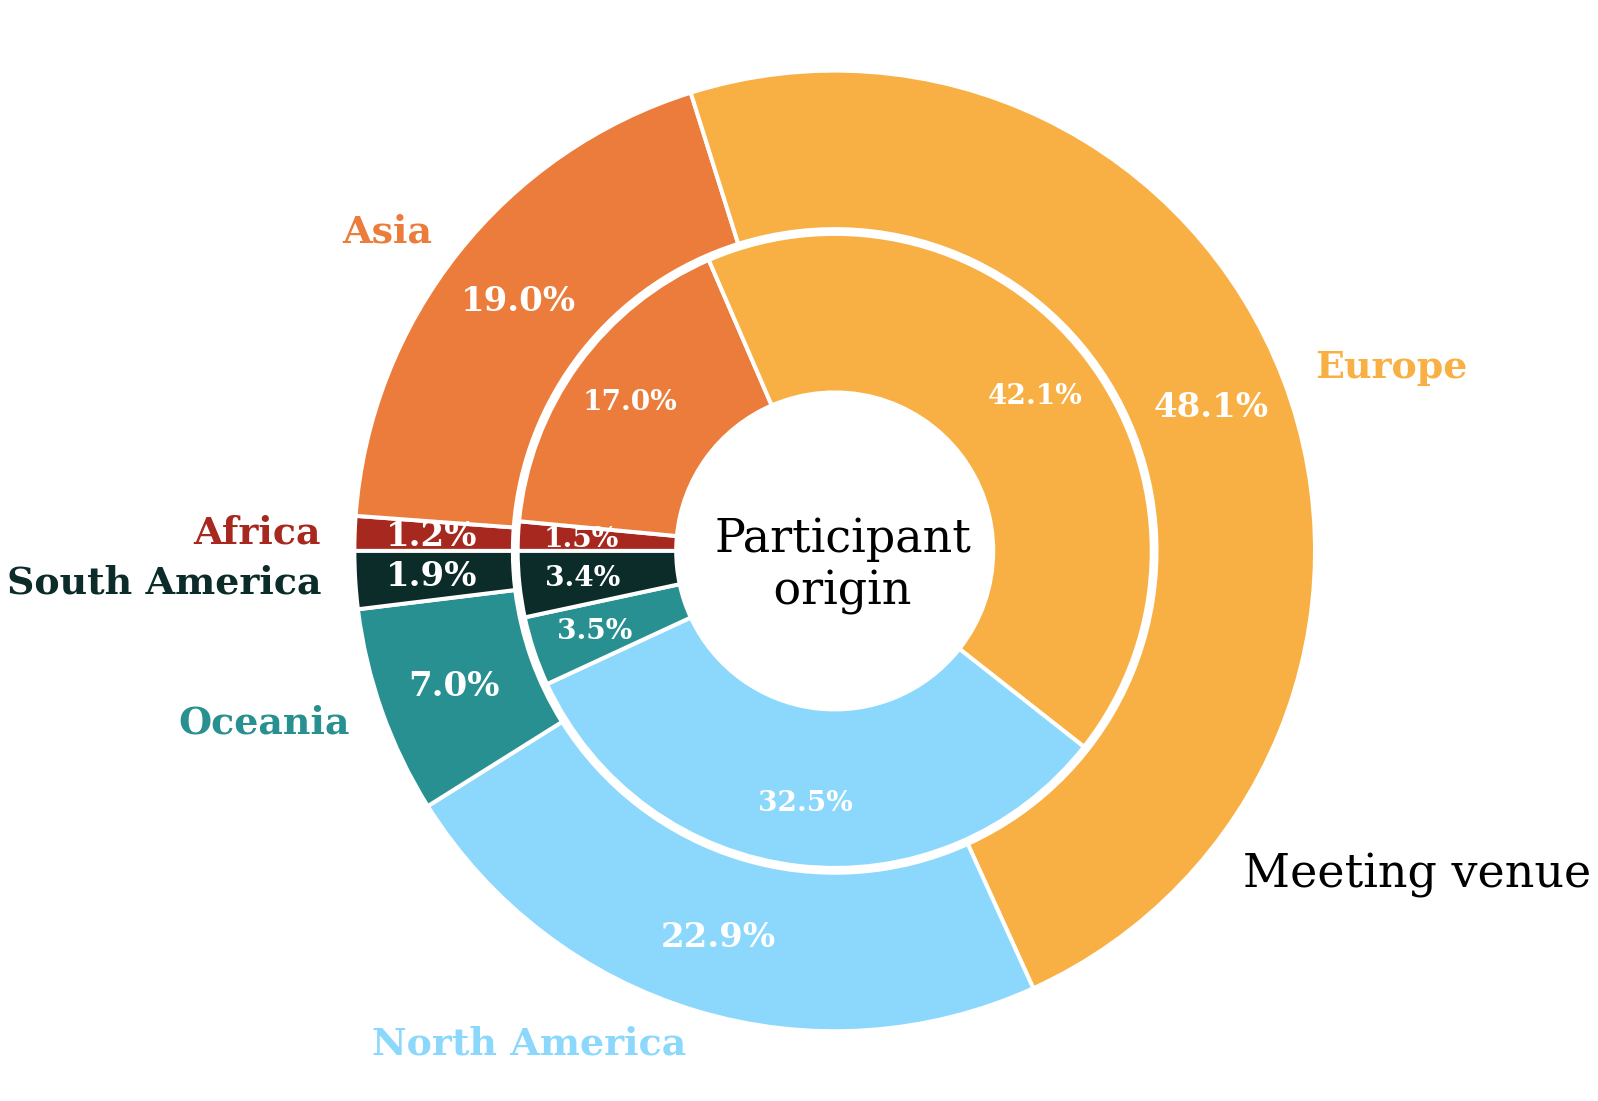

In [17]:
font_color = 'black'#'#525252'
hfont = {'fontname':'Calibri'}
size = 0.33

# New dataframe for plotting via multi-index, countries sorted to continents = inner donut
origin_df = dataframe.reset_index().groupby(["continent"])["conference_id"].count()
venue_df = data_agg.reset_index().groupby(["continent_venue"])["conference_id"].count()

# Get label names
inner_labels = origin_df.groupby('continent').sum().index.tolist()
outer_labels = origin_df.groupby('continent').sum().index.tolist()
print(inner_labels)

fig, ax = plt.subplots(figsize=(25,20))
a,b,c,d,e,f = [plt.cm.bone, plt.cm.copper, plt.cm.winter, plt.cm.summer, plt.cm.gist_heat, plt.cm.Wistia]

outer_colors = [color_africa, color_asia, color_europe, color_namerica, color_oceania, color_samerica]
inner_colors = [color_africa, color_asia, color_europe, color_namerica, color_oceania, color_samerica]

plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
patches, texts, pcts = ax.pie(venue_df, 
       radius=1, 
       startangle=180,
       counterclock=False, 
       colors=outer_colors, 
       labels=outer_labels,
       autopct='%1.1f%%',
       labeldistance=1.07,
       pctdistance=0.84,
       textprops={'color':font_color, 'size':34},
       wedgeprops=dict(width=size, linewidth=4,edgecolor='w'))

plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.setp(pcts, color='white', fontweight='bold')

for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(texts, fontweight='bold', size=38)

patches, texts, pcts =ax.pie(origin_df, 
       radius=0.99-size,
       startangle=180,
       counterclock=False, 
       #labels=inner_labels,
       rotatelabels=True,
       #labeldistance=1.1,
       pctdistance=0.8,
       textprops={'color':font_color,'fontsize': 28},
       autopct='%1.1f%%',
       colors=inner_colors,
       wedgeprops=dict(width=size, linewidth=4, edgecolor='w'))
ax.axis('equal')

ax.text(-0.25, -0.11, "Participant\n    origin", fontdict=None, fontsize=46)
ax.text(0.85, -0.7, "Meeting venue", fontdict=None, fontsize=46)

plt.setp(pcts, color='white', fontweight='bold')

plt.savefig('Output_from_Jupyter_Notebook/Donutchart_venue_vs_participants_allmeetings.png')